# First order Inch-worm test

Solving a non-interacting fermionic dimer system by hybridization expansion of one of the sites (here called the "bath" site).

In [1]:
using Revise

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/hugstr/.julia/packages/Revise/VxkZO/src/packagedef.jl:1369


In [2]:
import Test.@test

import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

import Keldysh; kd = Keldysh;
import KeldyshED; ked = KeldyshED;
import KeldyshED; op = KeldyshED.Operators;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192
┌ Info: Precompiling KeldyshED [675b6b9c-7c2f-11e9-3bf3-dfd4d61640f7]
└ @ Base loading.jl:1278
┌ Warning: Package KeldyshED does not have Keldysh in its dependencies:
│ - If you have KeldyshED checked out for development and have
│   added Keldysh as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KeldyshED
└ Loading Keldysh into KeldyshED from project dependency, future warnings for KeldyshED are suppressed.


In [3]:
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

In [40]:
β = 10. # Inverse temperature

μ = 0.1 # Chemical potential
V = -0.1 # Hybridization
ε = 0.1 # Bath site energy

H = - μ * op.n("0")
H_bath = ε * op.n("1")
H_hyb = V*(op.c_dag("0")*op.c("1") + op.c_dag("1")*op.c("0")) 

H_dimer = H + H_hyb + H_bath

# -- Real-time Kadanoff-Baym contour

contour = kd.twist(kd.Contour(kd.full_contour, tmax=1., β=β));
#grid = kd.TimeGrid(contour, npts_real=120, npts_imag=400);
grid = kd.TimeGrid(contour, npts_real=10, npts_imag=30);

# -- Bath hybridization function Δ(z, z')

Δ = begin
    soi = ked.Hilbert.SetOfIndices([["1"]])
    bidx = ked.Hilbert.IndicesType(["1"])
    ed = ked.EDCore(H_bath, soi)
    g_bath = ked.computegf(ed_bath, grid, [(bidx, bidx)], β)[1];
    return V * g_bath * V;
end

# -- test of two ways of indexing the TimeGF

begin
    tau_grid = grid[kd.imaginary_branch]
    τ_0 = tau_grid[1]
    τ_beta = tau_grid[end]
    g_bath_ref = g_bath[τ_0.idx:τ_beta.idx, τ_0.idx]

    @test g_bath_ref ≈ im .* g_bath[:matsubara]
end

Test Passed

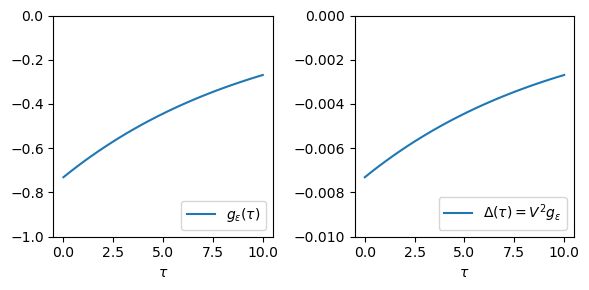

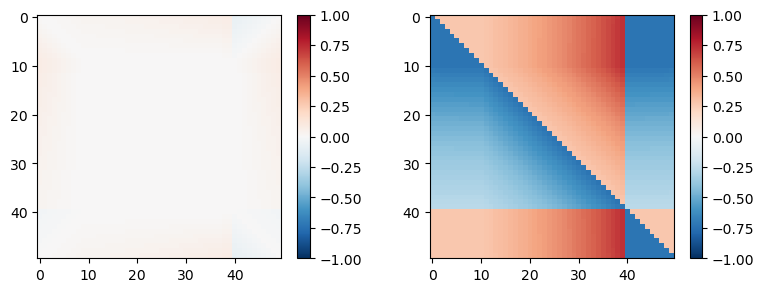

In [5]:
τ = kd.imagtimes(grid)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(τ, g_bath[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plt.subplot(1, 2, 2)
plt.plot(τ, Δ[:matsubara], label=plt.L"$\Delta(\tau) = V^2 g_\varepsilon$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-0.01, 0]);
plt.tight_layout()

plt.figure()
plot2d(g_bath.data)

# Pseudo-particle strong coupling types

In [50]:
#@enum KindEnum creation = Int8(1) annihilation = Int8(-1)

struct Operator
    kind::KindEnum
    idx::KeldyshED.Hilbert.IndicesType
    function Operator(kind::OperatorKindEnum, idx)
        return new(kind, idx)
    end
end

struct Interaction
    Oi::Operator # Initial operator
    Of::Operator # Final operator
    Δ::kd.TimeGF
end

O = Operator(:creation, KeldyshED.Hilbert.IndicesType(["0"]))

LoadError: invalid redefinition of type Operator

## Bare pseudo-particle propagator

In [26]:
import QInchworm.ppgf: atomic_ppgf

soi = KeldyshED.Hilbert.SetOfIndices([["0"]])
ed = KeldyshED.EDCore(H, soi)

println(ed)

G0 = atomic_ppgf(grid, ed, β)


Dimension of full Hilbert space: 2
Number of invariant subspaces: 2
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.1]
Ground state energy: -0.1



2-element Array{Keldysh.TimeGF,1}:
 [Complex{Float64}[0.0 - 1.0im]]
 [Complex{Float64}[0.0 - 1.0im]]

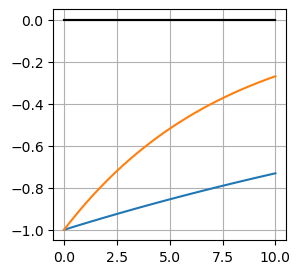

In [27]:
plt.figure(figsize=(3, 3))
for G0_s in G0
    g0_s = G0_s[kd.imaginary_branch, kd.imaginary_branch]
    g0_s = vcat(g0_s[:, 1]...)
        
    plt.plot(τ, real(g0_s), "-k")
    plt.plot(τ, imag(g0_s))
end
plt.grid(true)

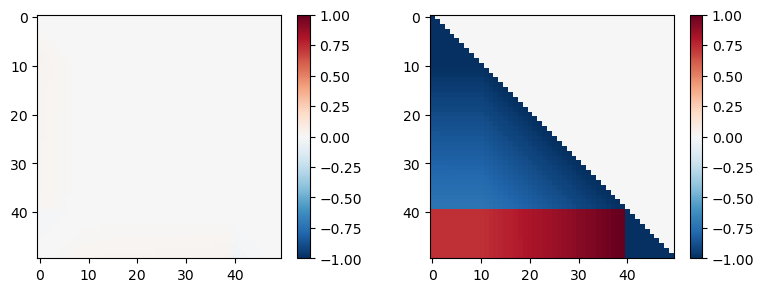

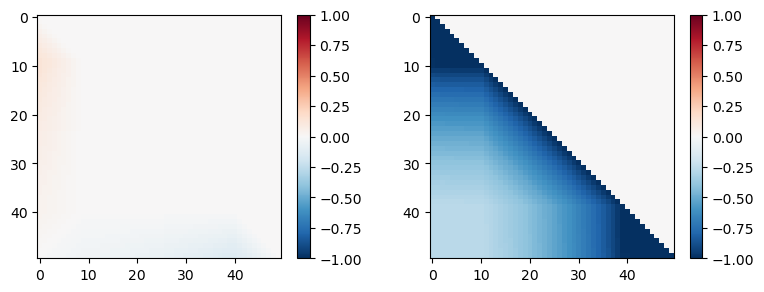

In [28]:
plt.figure(); plot2d(G0[1].data[1, 1, :, :])
plt.figure(); plot2d(G0[2].data[1, 1, :, :])

# Inch-worm configuration evaluator

## First order Inch-worm approximation

The dressed pseudo-particle propagator has the form

$$
G(\tau_f - 0) = 
G_0(\tau_f - \tau_w) \cdot G(\tau_w - 0) 
\\ + 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger_a(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c_b(\tau_1) G(\tau_1 - 0)
\right]
\\ 
+ 
\sum_{ab} \int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta_{ab}(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c_b(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c^\dagger_a(\tau_1) G(\tau_1 - 0)
\right]
$$

NB! To get the Matsubara component of $\Delta(\tau)$ from `Keldysh.jl` the values have to be scaled with $(-i)$

Here we restrict $\tau_f$ and $\tau_w$ (worm-time) to always be separated by a single time step, i.e. $\tau_f - \tau_w = \Delta \tau$.

The integrals are approximated using first order Riemann summation according to 

$$
\int_{\tau_w}^{\tau_f} d\tau_2 \, \int_0^{\tau_w} d\tau_1 \, 
(-i)\Delta(\tau_2 - \tau_1)
\left[ 
 G_0(\tau_f - \tau_2) c^\dagger(\tau_2) G_0(\tau_2 - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
\\
\approx
(\Delta \tau)^2 \sum_{\tau_1=0}^{\tau_w} \, 
(-i)\Delta(\tau_f - \tau_1)
\left[ 
 c^\dagger(\tau_f) G_0(\tau_f - \tau_w) 
 \cdot 
 G(\tau_w - \tau_1) c(\tau_1) G(\tau_1 - 0)
\right]
$$

In [29]:
import QInchworm.ppgf: operator_product
import QInchworm.ppgf: normalize, partition_function
import QInchworm.ppgf: set_matsubara
import QInchworm.ppgf: set_ppgf_initial_conditions


G = deepcopy(G0)

for G_s in G 
    G_s.data .*= 0.
end

set_ppgf_initial_conditions(G)

# --

tau_grid = grid[kd.imaginary_branch]

τ_0 = tau_grid[1]
τ_beta = tau_grid[end]

oidx = KeldyshED.Hilbert.IndicesType(["0"]);

Δτ = -imag(tau_grid[2].val.val - tau_grid[1].val.val)
#println("Δτ = $(Δτ)")

for (fidx, τ_f) in enumerate(tau_grid[2:end])
    τ_w = tau_grid[fidx]
    #println("τ_f = $(τ_f.idx), τ_w = $(τ_w.idx)")

    for (s0, G_s) in enumerate(G)
        #print("  s0 = $(s0)\n    ")
        
        # Zeroth order contrib
        val = -im * im^2 * G0[s0][τ_f, τ_w] * G[s0][τ_w, τ_0]
        
        # First order contrib -- verticies at τ_f and τ_1
        for τ_1 in tau_grid[1:fidx]
            #print("$(τ_1.idx) ")
            
            # FWD hyb ins: \beta --c+--\tau_w--c-- \tau
            let (p1, s1) = operator_product(ed, G, s0, τ_0, τ_w, [(τ_1, -1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G0, s1, τ_w, τ_f, [(τ_f, +1, oidx)])
                    if s2 == s0
                        val += Δτ^2 * p2 * p1 * Δ[τ_f, τ_1]
                    end
                end
            end
            
            # BWD hyb ins: \beta --c--\tau_w--c+-- \tau
            let (p1, s1) = operator_product(ed, G, s0, τ_0, τ_w, [(τ_1, +1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G0, s1, τ_w, τ_f, [(τ_f, -1, oidx)])
                    if s2 == s0
                        val += -Δτ^2 * p2 * p1 * Δ[τ_1, τ_f, false]
                    end
                end
            end
            
        end # τ_1

        set_matsubara(G_s, τ_f, val)

    end # s0
end # τ_f

Z = partition_function(G)
λ = log(Z) / β

println("Z = $Z")
println("λ = $λ")

normalize(G, β);

Z_0 = ked.partition_function(ed, β)
λ_0 = log(Z_0) / β # Pseudo-particle chemical potential (enforcing Tr[G0(β)]=Tr[ρ]=1)
G0_lambda_shift = atomic_ppgf(grid, ed, β, real(λ_0 + λ));

Z = 1.2562881709182103 + 0.0im
λ = 0.02281614771741555 + 0.0im


In [30]:
τ_i = grid[kd.imaginary_branch][1].idx
τ_f = grid[kd.imaginary_branch][end].idx

println(G[1][1, 1, τ_f, τ_i])
println(G[2][1, 1, τ_f, τ_i])

@test G[1][1, 1, τ_f, τ_i] + G[2][1, 1, τ_f, τ_i] ≈ -im
@test G[1][1, 1, τ_f, τ_i] ≈ 0.0 - 0.7105404445143371im
@test G[2][1, 1, τ_f, τ_i] ≈ 0.0 - 0.289459555485663im

0.0 - 0.7105404445143371im
0.0 - 0.289459555485663im


Test Passed

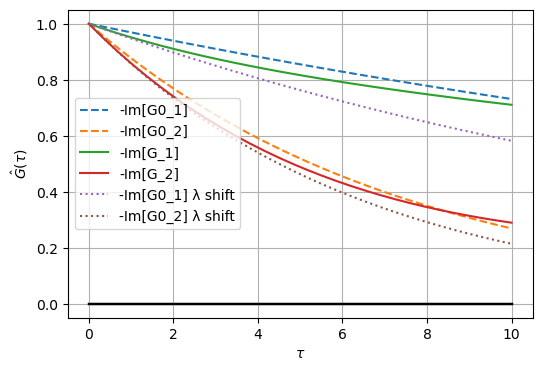

In [31]:
plt.figure(figsize=(6, 4))

for (s, G0_s) in enumerate(G0)
    g0_s = G0_s[kd.imaginary_branch, kd.imaginary_branch]
    g0_s = vcat(g0_s[:, 1]...)
    plt.plot(τ, -imag(g0_s), "--", label="-Im[G0_$(s)]")
    plt.plot(τ, real(g0_s), "-k")
end

for (s, G_s) in enumerate(G)
    g_s = G_s[kd.imaginary_branch, kd.imaginary_branch]
    g_s = vcat(g_s[:, 1]...)
    plt.plot(τ, -imag(g_s), "-", label="-Im[G_$(s)]")
    plt.plot(τ, real(g_s), "-k")
end

for (s, G_s) in enumerate(G0_lambda_shift)
    g_s = G_s[kd.imaginary_branch, kd.imaginary_branch]
    g_s = vcat(g_s[:, 1]...)
    plt.plot(τ, -imag(g_s), ":", label="-Im[G0_$(s)] λ shift")
    plt.plot(τ, real(g_s), "-k")
end


plt.xlabel(plt.L"$\tau$")
plt.ylabel(plt.L"$\hat{G}(\tau)$");
plt.legend(); 
#plt.ylim([0, 1.1]);
plt.grid(true)

# Real-time 1st order Inching

In [32]:
import QInchworm.ppgf: set_ppgf_symmetric

function first_order_real_time_inch(G0, G, N, z_i, z_w, z_f)
        
    grid = G[1].grid
    grid_im = grid[kd.imaginary_branch]
    grid_fwd = grid[kd.forward_branch]

    Δτ = -imag(grid_im[2].val.val - grid_im[1].val.val)
    Δt = grid_fwd[2].val.val - grid_fwd[1].val.val
    
    for (s0, (G_s, n)) in enumerate(zip(G, N))
        # Zeroth order contrib
        val = -im * im^2 * G[s0][z_f, z_w] * G0[s0][z_w, z_i]
        
        # First order contrib -- verticies at τ_f and τ_1
        for z_1 in grid[z_w.idx:z_f.idx]

            Δz_1 = z_1.val.domain == kd.imaginary_branch ? Δτ : Δt
            
            # FWD hyb ins: z_f --c+(z_1)--z_w--c(z_i)-- z_i
            let (p1, s1) = operator_product(ed, G0, s0, z_i, z_w, [(z_i, -1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G, s1, z_w, z_f, [(z_1, +1, oidx)])
                    if s2 == s0
                        val += -Δt * Δz_1 * p2 * p1 * Δ[z_1, z_i]
                    end
                end
            end
            
            # BWD hyb ins: z_f --c(z_1)--z_w--c+(z_i)-- z_i
            let (p1, s1) = operator_product(ed, G0, s0, z_i, z_w, [(z_i, +1, oidx)])
                if s1 > -1
                    p2, s2 = operator_product(ed, G, s1, z_w, z_f, [(z_1, -1, oidx)])
                    if s2 == s0
                        val += -Δt * Δz_1 * p2 * p1 * -Δ[z_i, z_1, false]
                    end
                end
            end
            
        end # z_1
        set_ppgf_symmetric(G_s, n, z_f, z_i, val)
        
    end # s0
end

first_order_real_time_inch (generic function with 1 method)

In [33]:
import LinearAlgebra: I
import QInchworm.ppgf: ppgf_real_time_initial_conditions
import QInchworm.ppgf: total_density_operator, operator_matrix_representation

# -- Setup real-time initial conditions

ppgf_real_time_initial_conditions(G, ed)

# -- Inch in real-time

N_op = total_density_operator(ed)
N = operator_matrix_representation(N_op, ed)

grid_bwd = grid[kd.backward_branch]
zb_i, zb_f = grid_bwd[1], grid_bwd[end]

grid_fwd = grid[kd.forward_branch]
zf_i, zf_f = grid_fwd[1], grid_fwd[end]

for z_i in grid[kd.backward_branch][end-1:-1:1]
    z_w = grid[z_i.idx + 1]
    #println(z_i)
    #println(z_w)
    #println("----------")
    fidx = zf_i.idx + zb_f.idx - z_i.idx
    zf = grid[zf_i.idx + zb_f.idx - z_i.idx]
    @test z_i.val.val ≈ zf.val.val

    #for z_f in grid[z_w.idx:zf.idx]
    for z_f in grid[z_w.idx:zb_f.idx] # Debug!
        #println("----------")
        #println("--> ", z_f)
        #println(z1)
        #println("----------")
        #G[1][z_f, z_i] += (0.5 - 0.5im) * I
        #G[1][z_f, z_i] += (0.5 - 0.5im) * I
        
        first_order_real_time_inch(G0_lambda_shift, G, N, z_i, z_w, z_f)
        #first_order_real_time_inch(G0, G, N, z_i, z_w, z_f)
    end
end

In [34]:
import QInchworm.ppgf: check_ppgf_real_time_symmetries
@test check_ppgf_real_time_symmetries(G, ed)

fi = grid[kd.forward_branch][1].idx
ff = grid[kd.forward_branch][end].idx

@test G[1][1, 1, ff, fi] ≈ -0.053568002346462175 - 0.9945189991807661im
@test G[2][1, 1, ff, fi] ≈ -0.153424373002968300 - 0.9866565474833044im

Test Passed

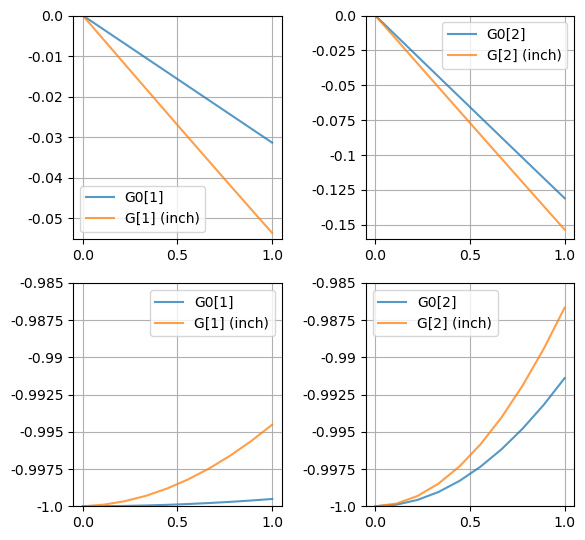

In [21]:
t = kd.realtimes(grid)

idx = grid[kd.backward_branch][end].idx
fi = grid[kd.forward_branch][1].idx
ff = grid[kd.forward_branch][end].idx
ylim = [-1, -0.985]

plt.figure(figsize=(6, 5.5))

plt.subplot(2, 2, 1)
plt.plot(t, real(G0[1][1, 1, fi:ff, fi]), "-", label="G0[1]", alpha=0.75);
plt.plot(t, real(G[1][1, 1, fi:ff, fi]), "-", label="G[1] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -0.05:0.01:0.0
plt.yticks(tick, tick)
plt.ylim([-0.055, 0]);

plt.subplot(2, 2, 2)
plt.plot(t, real(G0[2][1, 1, fi:ff, fi]), "-", label="G0[2]", alpha=0.75);
plt.plot(t, real(G[2][1, 1, fi:ff, fi]), "-", label="G[2] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
#plt.ylim(ylim);
tick = -0.15:0.025:0.0
plt.yticks(tick, tick)
plt.ylim([-0.16, 0]);

plt.subplot(2, 2, 3)
plt.plot(t, imag(G0[1][1, 1, fi:ff, fi]), "-", label="G0[1]", alpha=0.75);
plt.plot(t, imag(G[1][1, 1, fi:ff, fi]), "-", label="G[1] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);

plt.subplot(2, 2, 4)
plt.plot(t, imag(G0[2][1, 1, 1:idx, 1]), "-", label="G0[2]", alpha=0.75);
plt.plot(t, imag(G[2][1, 1, 1:idx, 1]), "-", label="G[2] (inch)", alpha=0.75);
plt.legend();
plt.grid(true);
tick = -1.:0.0025:0.0
plt.yticks(tick, tick)
plt.ylim(ylim);

# -- 

plt.tight_layout()

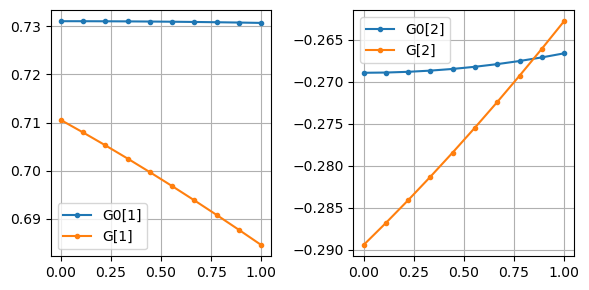

In [22]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(t, imag(G0[1][1, 1, fi:ff, idx]), ".-", label="G0[1]");
plt.plot(t, imag(G[1][1, 1, fi:ff, idx]), ".-", label="G[1]");
plt.legend();
plt.grid(true);
#plt.ylim(ylim);

plt.subplot(1, 2, 2)
plt.plot(t, imag(G0[2][1, 1, fi:ff, idx]), ".-", label="G0[2]");
plt.plot(t, imag(G[2][1, 1, fi:ff, idx]), ".-", label="G[2]");
plt.legend();
plt.grid(true);
#plt.ylim(ylim);
plt.tight_layout()

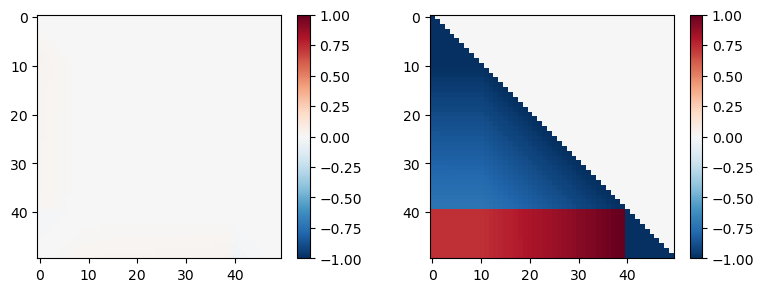

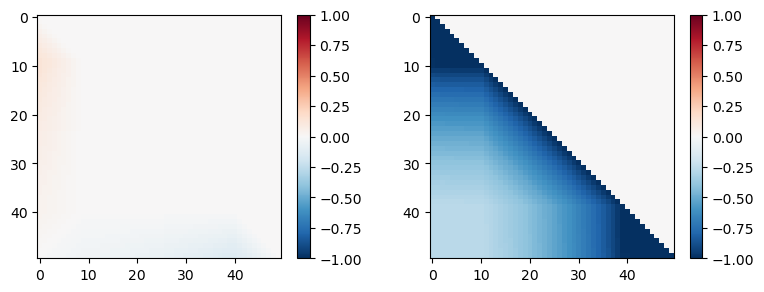

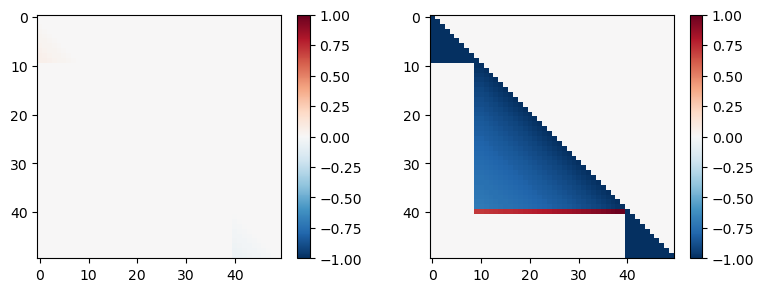

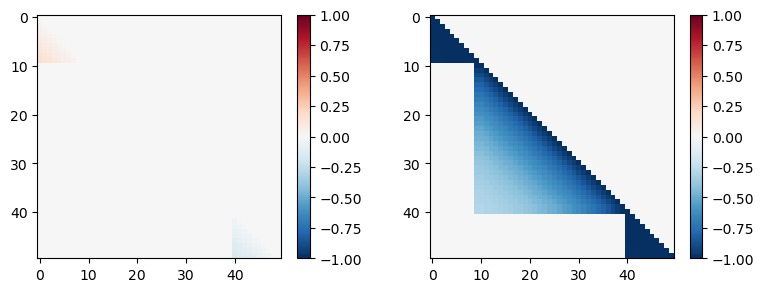

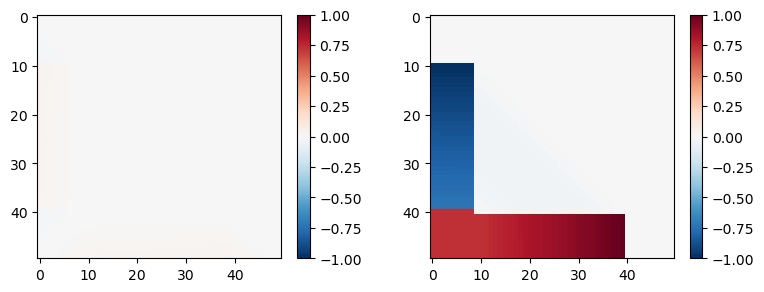

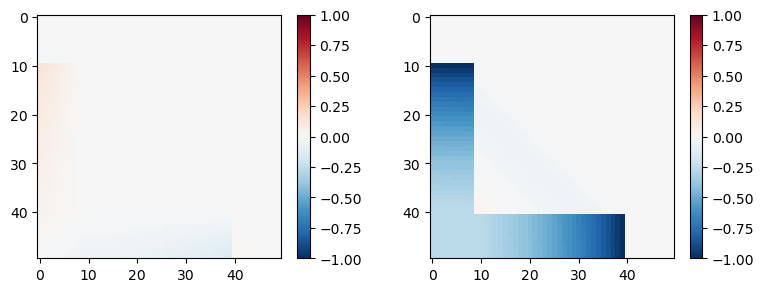

In [35]:
plot2d(G0[1].data[1, 1, :, :])
plot2d(G0[2].data[1, 1, :, :])
plot2d(G[1].data[1, 1, :, :])
plot2d(G[2].data[1, 1, :, :])
plot2d(G0[1].data[1, 1, :, :] - G[1].data[1, 1, :, :])
plot2d(G0[2].data[1, 1, :, :] - G[2].data[1, 1, :, :])

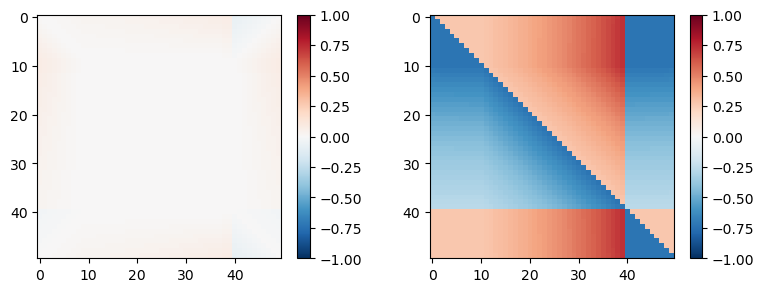

In [18]:
plot2d(g_bath.data)